In [9]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')

from features import *

In [3]:
features = [
  "download_avg", 
  "download_std",
  "diff_pkts",
  "peak_avg",
  "peak_std",
  "peak_amount", 
  "seconds_per_peak", 
  "psd_std", 
  "prominence_std",
  "max_prominence",
  "download_cv",
  "upload_cv",
  "rolling_cv" 
]

size = 300

In [ ]:
two_four_dir = ['../data/240p/' + fp for fp in os.listdir('../data/240p')]
three_six_dir = ['../data/360p/' + fp for fp in os.listdir('../data/360p')]
four_eight_dir = ['../data/480p/' + fp for fp in os.listdir('../data/480p')]
seven_two_dir = ['../data/720p/' + fp for fp in os.listdir('../data/720p')]
ten_eight_dir = ['../data/1080p/' + fp for fp in os.listdir('../data/1080p')]

feat_240 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in two_four_dir]))
feat_360 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in three_six_dir]))
feat_480 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in four_eight_dir]))
feat_720 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in seven_two_dir]))
feat_1080 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in ten_eight_dir]))

feat_df_240 = pd.DataFrame(columns=features, data=feat_240)
feat_df_240['resolution'] = 1

feat_df_360 = pd.DataFrame(columns=features, data=feat_360)
feat_df_360['resolution'] = 2

feat_df_480 = pd.DataFrame(columns=features, data=feat_480)
feat_df_480['resolution'] = 3

feat_df_720 = pd.DataFrame(columns=features, data=feat_720)
feat_df_720['resolution'] = 4

feat_df_1080 = pd.DataFrame(columns=features, data=feat_1080)
feat_df_1080['resolution'] = 5

## Baseline Model - 3 Resolutions

We started with a basic model with 3 even spaced resolutions: 240p, 480p, and 1080p. Our intention was to ensure that our features were sufficient enough to define distinctions between fairly spaced classes before attempting more defined predictions. Through some experimentation, we decided to move forward with a Random Forest model. Random Forest is better attuned for multiclassification situations like ours and its inherent randomness of feature selection will overcome so the correlation within our features. Random Forest is also an ideal algorithm since we don't need to scale (standardize or normalize) our data due to its 

In [28]:
training = pd.concat((
  feat_df_240,
  feat_df_480,
  feat_df_1080
))

training.shape

(234, 14)

In [29]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, criterion = 'entropy', min_samples_split = 2, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Baseline Accuracy: ' + str(accuracy_score(y_test, y_pred)))
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

Random Forest - Baseline Accuracy: 0.9436619718309859


Predicted Resolution,1,3,5
Actual Resolution,,,
1,23,0,0
3,1,22,1
5,0,2,22


Text(0, 0.5, 'Features')

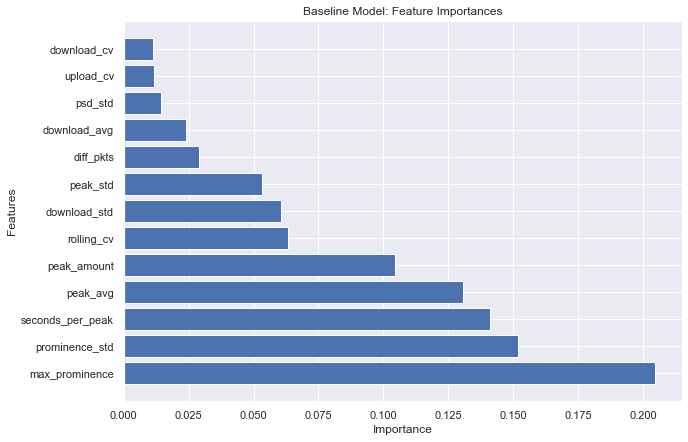

In [30]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sns.set(rc={'figure.figsize':(10,7)})
plt.barh(np.array(features)[indices],importances[indices])
plt.title('Baseline Model: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

## Expanded Model - 5 Resolutions

In [31]:
training = pd.concat((
  feat_df_240,
  feat_df_360,
  feat_df_480,
  feat_df_720,
  feat_df_1080
))

training.shape

(388, 14)

In [33]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, criterion = 'entropy', min_samples_split = 2, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Expanded Model Accuracy: ' + str(accuracy_score(y_test, y_pred)))
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

Random Forest - Expanded Model Accuracy: 0.6923076923076923


Predicted Resolution,1,2,3,4,5
Actual Resolution,,,,,
1,14,2,0,0,0
2,2,11,2,0,0
3,0,4,9,2,1
4,0,0,6,6,3
5,1,0,0,1,14


Text(0, 0.5, 'Features')

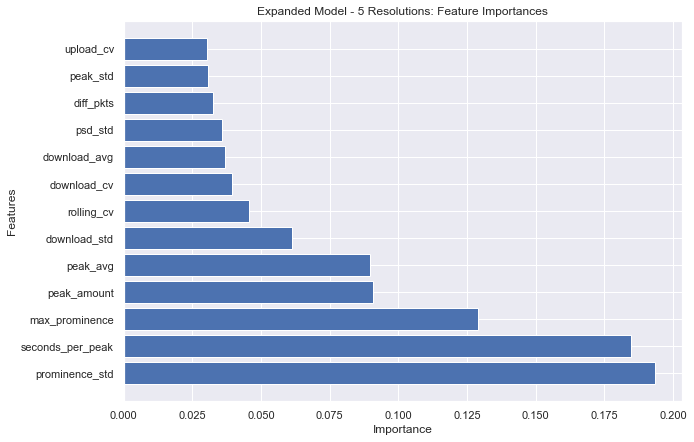

In [34]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sns.set(rc={'figure.figsize':(10,7)})
plt.barh(np.array(features)[indices], importances[indices])
plt.title('Expanded Model - 5 Resolutions: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

## Expanded Model - Binned Resolutions

In [35]:
feat_df_240 = pd.DataFrame(columns=features, data=feat_240)
feat_df_240['resolution'] = 1

feat_df_360 = pd.DataFrame(columns=features, data=feat_360)
feat_df_360['resolution'] = 3

feat_df_480 = pd.DataFrame(columns=features, data=feat_480)
feat_df_480['resolution'] = 3

feat_df_720 = pd.DataFrame(columns=features, data=feat_720)
feat_df_720['resolution'] = 5

feat_df_1080 = pd.DataFrame(columns=features, data=feat_1080)
feat_df_1080['resolution'] = 5

training = pd.concat((
  feat_df_240,
  feat_df_360,
  feat_df_480,
  feat_df_720,
  feat_df_1080
))

training.shape

(388, 14)

In [36]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, criterion = 'entropy', min_samples_split = 2, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Binned Resolutions Accuracy: ' + str(accuracy_score(y_test, y_pred)))
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

Random Forest - Binned Resolutions Accuracy: 0.8846153846153846


Predicted Resolution,1,3,5
Actual Resolution,,,
1,16,0,0
3,4,27,0
5,1,4,26


Text(0, 0.5, 'Features')

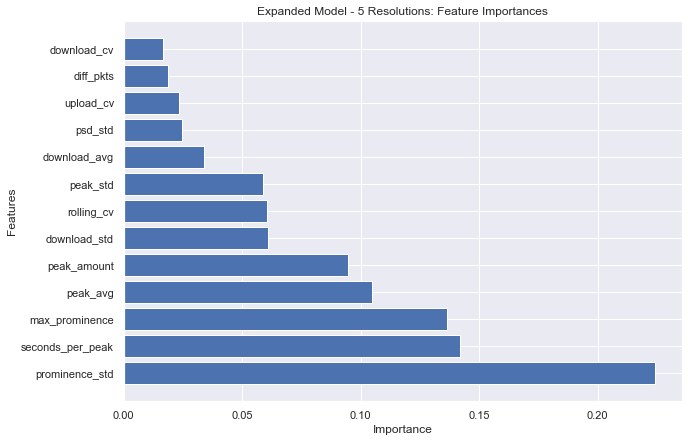

In [37]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sns.set(rc={'figure.figsize':(10,7)})
plt.barh(np.array(features)[indices], importances[indices])
plt.title('Expanded Model - 5 Resolutions: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

In [ ]:
rf_clf = RandomForestClassifier()
parameters_rf = {"n_estimators": [10, 15, 20, 25, 30], "criterion": ["gini", "entropy"], "max_features": ["auto", "sqrt", "log2"], 
                 "max_depth": [2, 3, 5, 10], "min_samples_split": [2, 3, 5, 10]}

grid_rf = GridSearchCV(rf_clf, parameters_rf, scoring=make_scorer(accuracy_score))
grid_rf.fit(X_train, y_train)

rf_clf = grid_rf.best_estimator_

rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)

print("The Score for Random Forest is: " + str(acc_rf))